## Этапы выполнения проекта машинного обучения
1. **Постановка задачи** (формирулирование проблемы, определения типа задачи: классификация/кластеризация/регрессия);
2. **Получение данных для ислледования** (загрузка данных для исследования);
3. **Разведывательный анализ** (описание доступных признаков, определение типов рассматриваемых данных, определение признаков содержащих пропущенные значения, оценка распределений значений признаков, оценка корреляций значений признаков с предсказываемой переменной);
4. **Предварительная обработка признаков** (заполнение пропущенных значений признаков, конструирование новых признаков на основе существующих, кодирование и масштабирование признаков);
5. **Обучение моделей и натсройка гиперпараметров** (разделение набора данных на тренировочныхй, тестовый и валидационный, выбор методов оценки моделей, обучение моделей на тренировочных данных, настройка гиперпараметров, выбор модели на тестовых данных);
6. **Оценка модели** (оценка качества модели на валидационных данных, оценка распределения ошибок).

## 1. Постановка задачи

В этой рабочей тетради используется набор данных **Ames Housing** из *kaggle* соревнования (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

Набор данных **Ames Housing** состоит из 79 объясняющих переменных, описывающих (почти) каждый аспект жилых домов в Эймсе, штат Айова. Задача состоит в том, чтобы спрогнозировать цену продажи каждого дома. Для каждого идентификатора в тестовом наборе необходимо спрогнозировать значение переменной `SalePrice`.

Представленные материалы оцениваются по среднеквадратичной ошибке (*RMSE*) между логарифмом прогнозируемого значения и логарифмом наблюдаемой цены продажи (данная метрика используется в *kaggle* соревновании). 

## 2. Получение данных

#### Импорт бибилиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing, base, model_selection, ensemble, linear_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Загрузка данных

In [3]:
# Загрузим данные (предоставляются данные уже разделенные на обучающий и тестовый набор)
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

# Оценим размеры обучающего и тестового наборов
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [4]:
# Целевая переменная
target_var = 'SalePrice'
targets = df_train[target_var]

# Создаем обьединенный набор данных для выполнения предварительной обработки признаков
unite = pd.concat([df_train.drop([target_var], axis=1), df_test])
unite = unite.drop(['Id',], axis=1)
unite.shape

(2919, 79)

## 3. Разведывательный анализ

#### Выведем случайные экземпляры данных

In [5]:
# Зафиксируем 'случайное состояние' (чтобы разные вызовы рандомного генератора имели одинаковый результат)
random_state = 42
# Выведем случайные экземпляры данных
df_train.sample(10, random_state=random_state)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
892    893          20       RL         70.0     8414   Pave   NaN      Reg   
1105  1106          60       RL         98.0    12256   Pave   NaN      IR1   
413    414          30       RM         56.0     8960   Pave  Grvl      Reg   
522    523          50       RM         50.0     5000   Pave   NaN      Reg   
1036  1037          20       RL         89.0    12898   Pave   NaN      IR1   
614    615         180       RM         21.0     1491   Pave   NaN      Reg   
218    219          50       RL          NaN    15660   Pave   NaN      IR1   
1160  1161         160       RL         24.0     2280   Pave   NaN      Reg   
649    650         180       RM         21.0     1936   Pave   NaN      Reg   
887    888          50       RL         59.0    16466   Pave   NaN      IR1   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
892          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1105         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
413          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
522          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1036         HLS    AllPub  ...        0    NaN    NaN         NaN       0   
614          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
218          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1160         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
649          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
887          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
892       2   2006        WD         Normal     154500  
1105      4   2010        WD         Normal     325000  
413       3   2010        WD         Normal     115000  
522      10   2006        WD         Normal     159000  
1036      9   2009        WD         Normal     315500  
614       5   2010        WD         Normal      75500  
218       5   2008        WD         Normal     311500  
1160      7   2010        WD         Normal     146000  
649      12   2007        WD         Normal      84500  
887       4   2008        WD         Normal     135500  

[10 rows x 81 columns]

#### Описание признаков в наборе данных

In [6]:
# Список всех признаков
print(df_train.columns.values)

['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleTy

1. `Id` Id дома;
2. `SalePrice` Стоимость дома в долларах, предсказываемый признак;
3. `MSSubClass` Класс здания;
4. `MSZoning` Класс зоны согласно общей классификации зонирования;
5. `LotFrontage` Длинна участка со стороны улица в футах;
6. `LotArea` Размер участка в квадратных футах;
7. `Street` Тип доступа к дороге;
8. `Alley`  Тип доступа в переулок;
9. `LotShape` Форма участка;
10. `LandContour` Ровность недвижимости;
11. `Utilities` Доступные коммунальные услуги;
12. `LotConfig` Конфигурация участка;
13. `LandSlope` Наклон поверхности земли на участке;
14. `Neighborhood` Район города *Ames*;
15. `Condition1` Близость к различным обьектам;
16. `Condition2` Близость к различным обьектам (если больше одного отличается от предыдуего);
17. `BldgType` Тип дома;
18. `HouseStyle` Архитектурный стиль дома;
19. `OverallQual` Общее качество материала и отделки (по шкале от 1 до 10);
20. `OverallCond` Общая оценка состояния (по шкале от 1 до 10);
21. `YearBuilt` Дат постройки;
22. `YearRemodAdd` Дата ремонта;
23. `RoofStyle` Тип крыши;
24. `RoofMatl` Материал крыши;
25. `Exterior1st` Материал внешней отделки дома;
26. `Exterior2nd` Материал внешней отделки дома (если материалы совпадают равен предыдущему);
27. `MasVnrType` Тип каменной облицовки;
28. `MasVnrArea` Площадь каменной облицовки в квадратный футах;
29. `ExterQual` Качество материалов экстерьера;
30. `ExterCond` Оценка состояния материалов экстерьера;
31. `Foundation` Тип фундамента;
32. `BsmtQual` Высота подвала;
33. `BsmtCond` Общее состояние подвала;
34. `BsmtExposure` Уровень стен подвала (на уровне сада или на уровне тротуара);
35. `BsmtFinType1` Качество отделки подвала 1 материалом;
36. `BsmtFinSF1` Площадь отделки подвала 1 материалом в квадратный футах;
37. `BsmtFinType2` Качество отделки подвала 2 материалом;
38. `BsmtFinSF2` Площадь отделки подвала 2 материалом в квадратный футах;
39. `BsmtUnfSF` Неотделанная площадь подвала в квадратный футах;
40. `TotalBsmtSF` Общая площадь подвала;
41. `Heating` Тип отопления;
42. `HeatingQC` Качество отопления;
43. `CentralAir` Кондиционирование;
44. `Electrical` Тип электрефикации;
45. `1stFlrSF` Площадь 1го этажа в квадратный футах;
46. `2ndFlrSF` Площадь 2го этажа в квадратный футах;
47. `LowQualFinSF` Некачественная отделка дома в квадратный футах;
48. `GrLivArea` Жилая площадь над уровнем земли в квадратный футах;
49. `BsmtFullBath` Совмещенные санузлы в подвале;
50. `BsmtHalfBath` Раздельные санузлы в подвале;
51. `FullBath` Совмещенные санузлы;
52. `HalfBath` Раздельные санузлы;
53. `BedroomAbvGr` Число спален;
54. `KitchenAbvGr` Число кухонь;
55. `KitchenQual` Качество кухонь;
56. `TotRmsAbvGrd` Общее число комнат (без учета ванных);
57. `Functional` Рейтинг функциональности дома;
58. `Fireplaces` Число каминов;
59. `FireplaceQu` Качество каминов;
60. `GarageType`  Тип гаража;
61. `GarageYrBlt` Год постройки гаража;
62. `GarageFinish` Внутренния отделка гаража;
63. `GarageCars` Вместимость автомобиля в машинах;
64. `GarageArea` Размер гаража в квадратных футах;
65. `GarageQual` Качество гаража;
66. `GarageCond` Состояние гаража;
67. `PavedDrive` Асфальтированная подьезная дорога;
68. `WoodDeckSF` Площадь деревянного настила в квадратных футах;
69. `OpenPorchSF` Площадь открытой веранды в квадратных футах;
70. `EnclosedPorch` Площадь крытой веранды в квадратных футах;
71. `3SsnPorch` Площадь всесезонной веранды в квадратных футах;
72. `ScreenPorch` Площадь застекленной веранды в квадратных футах;
73. `PoolArea` Площадь бассейна в квадратных футах;
74. `PoolQC` Качество бассейна;
75. `Fence` Качество забора;
76. `MiscFeature` Дополнительные функции не вошедшые в другие категории
77. `MiscVal` Стоимость в $ дополнительных функций;
78. `MoSold` Месяц продажи;
79. `YrSold` год продажи;
80. `SaleType` тип продажи;
81. `SaleCondition` Условие продажи;

#### Найдем признаки содержащие пропущенные значения

In [7]:
# Выбираем признаки, содержащие пропущенные значения
nan_cols = unite.columns[unite.isna().any()]
unite[nan_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      2915 non-null   object 
 1   LotFrontage   2433 non-null   float64
 2   Alley         198 non-null    object 
 3   Utilities     2917 non-null   object 
 4   Exterior1st   2918 non-null   object 
 5   Exterior2nd   2918 non-null   object 
 6   MasVnrType    1153 non-null   object 
 7   MasVnrArea    2896 non-null   float64
 8   BsmtQual      2838 non-null   object 
 9   BsmtCond      2837 non-null   object 
 10  BsmtExposure  2837 non-null   object 
 11  BsmtFinType1  2840 non-null   object 
 12  BsmtFinSF1    2918 non-null   float64
 13  BsmtFinType2  2839 non-null   object 
 14  BsmtFinSF2    2918 non-null   float64
 15  BsmtUnfSF     2918 non-null   float64
 16  TotalBsmtSF   2918 non-null   float64
 17  Electrical    2918 non-null   object 
 18  BsmtFullBath  2917 non-null   flo

#### Распределение значений числовых признаков

In [8]:
df_train.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
T

#### Распределение значений категориальныз признаков

In [9]:
df_train.describe(include=['O']).T

count unique      top  freq
MSZoning       1460      5       RL  1151
Street         1460      2     Pave  1454
Alley            91      2     Grvl    50
LotShape       1460      4      Reg   925
LandContour    1460      4      Lvl  1311
Utilities      1460      2   AllPub  1459
LotConfig      1460      5   Inside  1052
LandSlope      1460      3      Gtl  1382
Neighborhood   1460     25    NAmes   225
Condition1     1460      9     Norm  1260
Condition2     1460      8     Norm  1445
BldgType       1460      5     1Fam  1220
HouseStyle     1460      8   1Story   726
RoofStyle      1460      6    Gable  1141
RoofMatl       1460      8  CompShg  1434
Exterior1st    1460     15  VinylSd   515
Exterior2nd    1460     16  VinylSd   504
MasVnrType      588      3  BrkFace   445
ExterQual      1460      4       TA   906
ExterCond      1460      5       TA  1282
Foundation     1460      6    PConc   647
BsmtQual       1423      4       TA   649
BsmtCond       1423      4       TA  1311
BsmtExposure   1422      4       No   953
BsmtFinType1   1423      6      Unf   430
BsmtFinType2   1422      6      Unf  1256
Heating        1460      6     GasA  1428
HeatingQC      1460      5       Ex   741
CentralAir     1460      2        Y  1365
Electrical     1459      5    SBrkr  1334
KitchenQual    1460      4       TA   735
Functional     1460      7      Typ  1360
FireplaceQu     770      5       Gd   380
GarageType     1379      6   Attchd   870
GarageFinish   1379      3      Unf   605
GarageQual     1379      5       TA  1311
GarageCond     1379      5       TA  1326
PavedDrive     1460      3        Y  1340
PoolQC            7      3       Gd     3
Fence           281      4    MnPrv   157
MiscFeature      54      4     Shed    49
SaleType       1460      9       WD  1267
SaleCondition  1460      6   Normal  1198

### Выполним визуальный анализ данных

#### Сгруппируем переменные по категориям для анализа
*В данном примере используеися группировка признаков по различным категориям а не по типам данных, т.к. такой способ позволяет лучше понять контекст каждой переменной.*

In [10]:
# Характеристики подвала
bsmt_cols = [
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 
    'BsmtUnfSF', 'TotalBsmtSF',
]

# Характеристики гаража
garage_cols = [
    'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'
]

# Характеристики веранды
porch_cols = [
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
]

# Характеристики сделки
sale_cond_cols = [
    'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
]

# Характеристики участка
lot_cols = [
    'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'PavedDrive', 
]

# Характеристики дома
house_cols = [
    'MSSubClass', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 
    'ExterCond', 'Foundation', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'Functional', 'WoodDeckSF'
]

# Удобства
comfort_cols = [
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Fireplaces', 'FireplaceQu', 'PoolArea', 'PoolQC',
    'Fence', 'MiscFeature', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
    'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
]

In [11]:
# Настройка параметров визуализации
sns.set_style("whitegrid")
palette = sns.color_palette('pastel')
edgecolor = '#222222'
shrink = .95
bins = 12

#### Выведем распределение значений целевой переменной

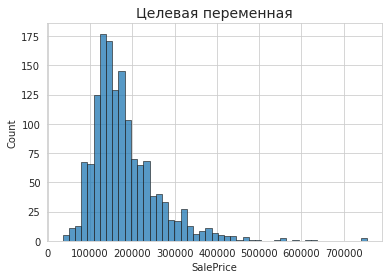

In [12]:
plt.figure(figsize=(6, 4))
plt.title(label="Целевая переменная", fontsize=14)
sns.histplot(data=df_train, x=target_var, edgecolor=edgecolor, palette=palette,)
plt.show()

#### Метод для визуализации гистограмм распределенния сгруппированных данных

In [13]:
def create_group_graphic(data, group, group_name='', n_cols=5, scale_figsize_x=4, scale_figsize_y=3,):
    # Число строк для вывода данных
    n_rows = int(len(group) / n_cols) + 1
    # Задаем размер сцены
    figsize = np.array([n_cols, n_rows]) * [scale_figsize_x, scale_figsize_y]
    plt.figure(figsize=figsize)
    # Подпись сцены
    plt.suptitle(group_name)

    # Стриом гистограмму для каждой переменной в группу
    for i, col in enumerate(group):
        # Создаем подграфик
        plt.subplot(n_rows, n_cols, i+1,)
        # Подпись сверху графика
        plt.title(label=f"Histogramm of {col}",)
        # Гистограмма распределения
        ax = sns.histplot(
            data=data, x=col, edgecolor=edgecolor, palette=palette, shrink=shrink, bins=bins,
        )
    # Автоматическая настройка интервалов между подграфиками
    plt.tight_layout()

#### Распределение значений характеристик подвала

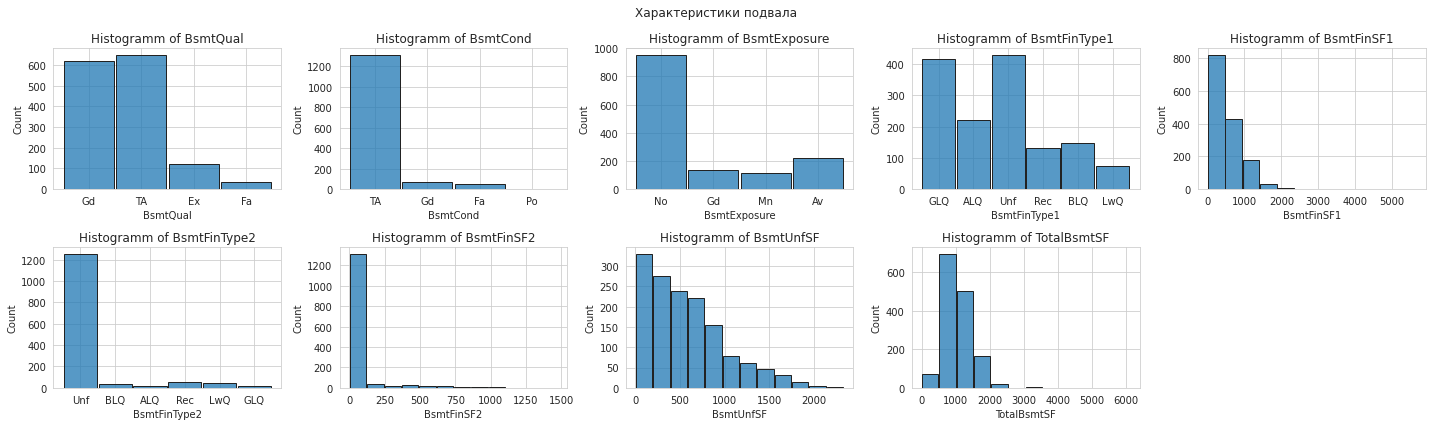

In [14]:
create_group_graphic(df_train, bsmt_cols, 'Характеристики подвала',)

#### Распределение значений характеристик гаража

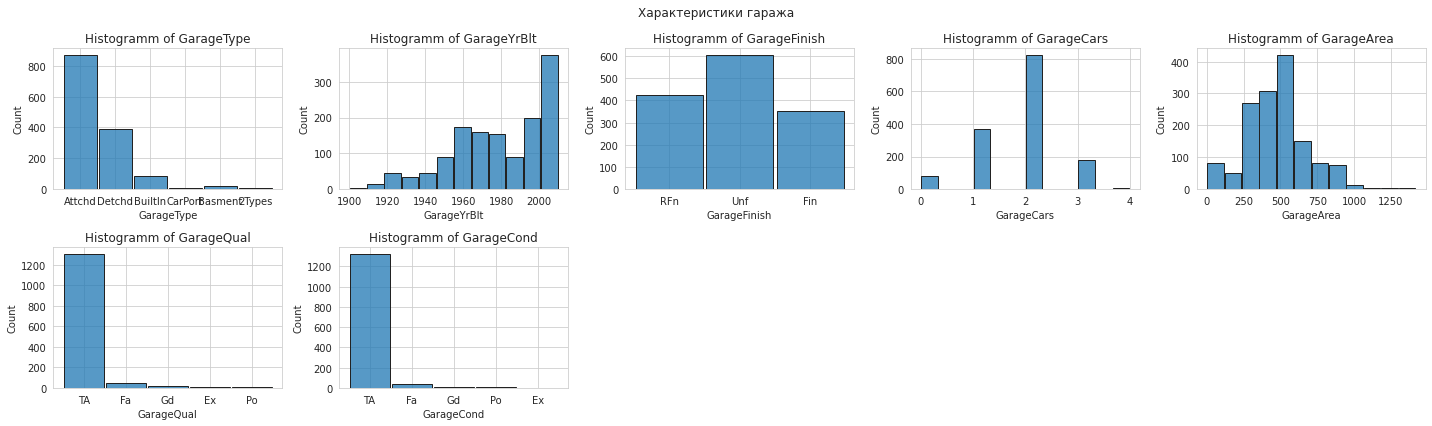

In [15]:
create_group_graphic(df_train, garage_cols, 'Характеристики гаража',)

#### Распределение значений характиристик веранды

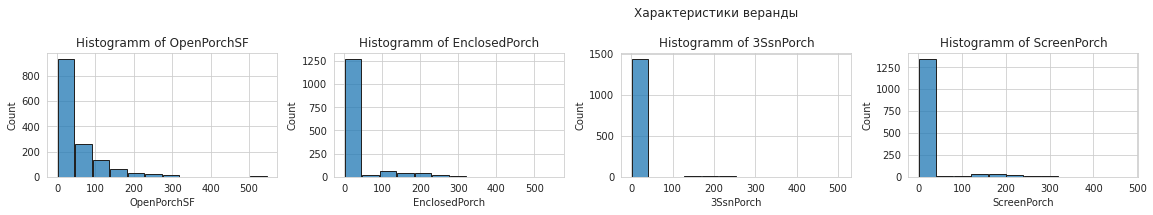

In [16]:
create_group_graphic(df_train, porch_cols, 'Характеристики веранды',)

#### Распределение значений характиристик сделки

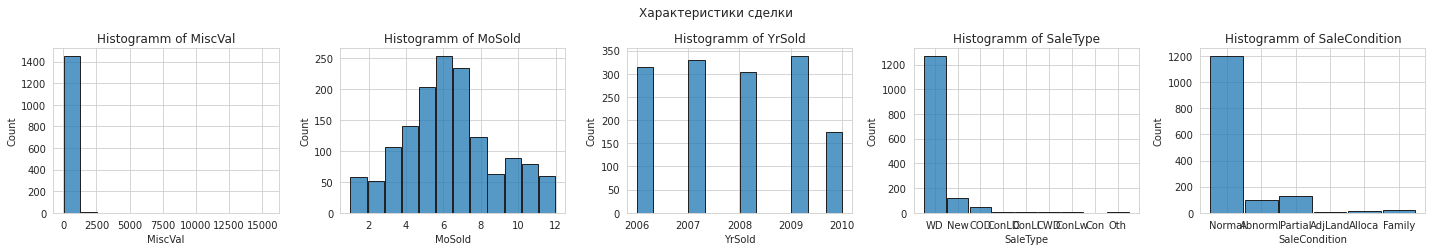

In [17]:
create_group_graphic(df_train, sale_cond_cols, 'Характеристики сделки',)

#### Распределение значений характиристик участка

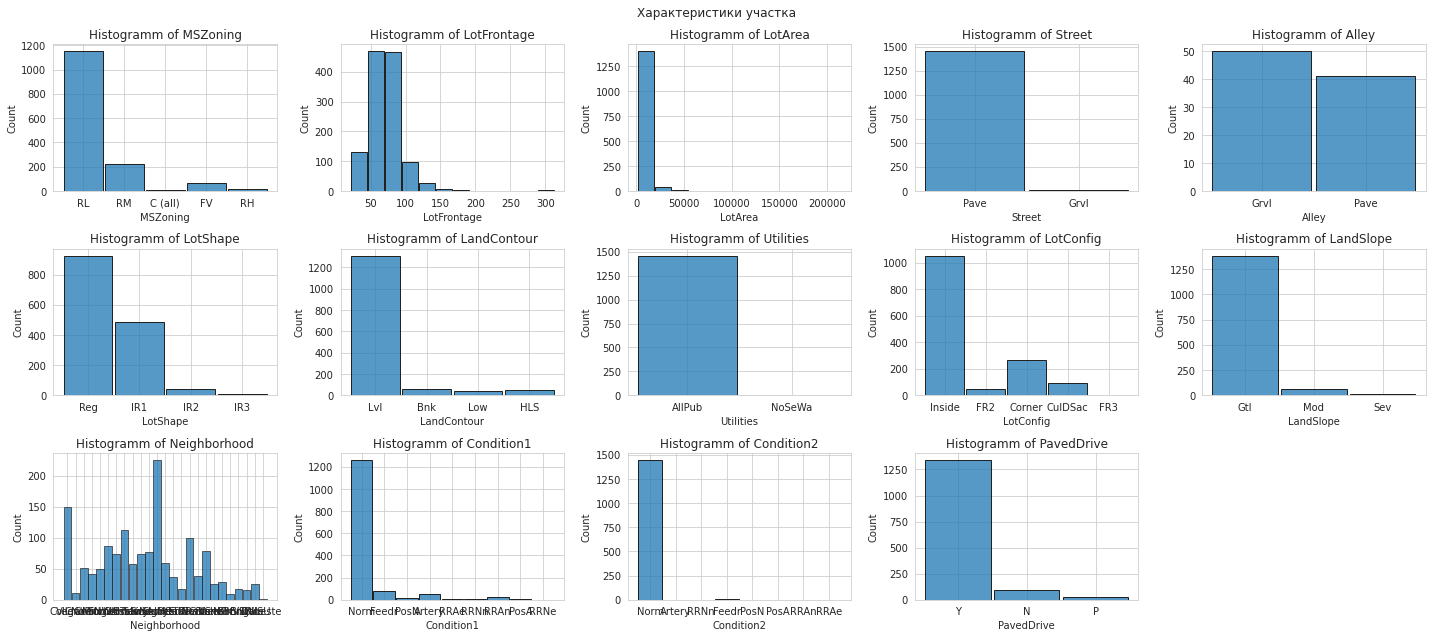

In [18]:
create_group_graphic(df_train, lot_cols, 'Характеристики участка',)

#### Распределение значений характиристик дома

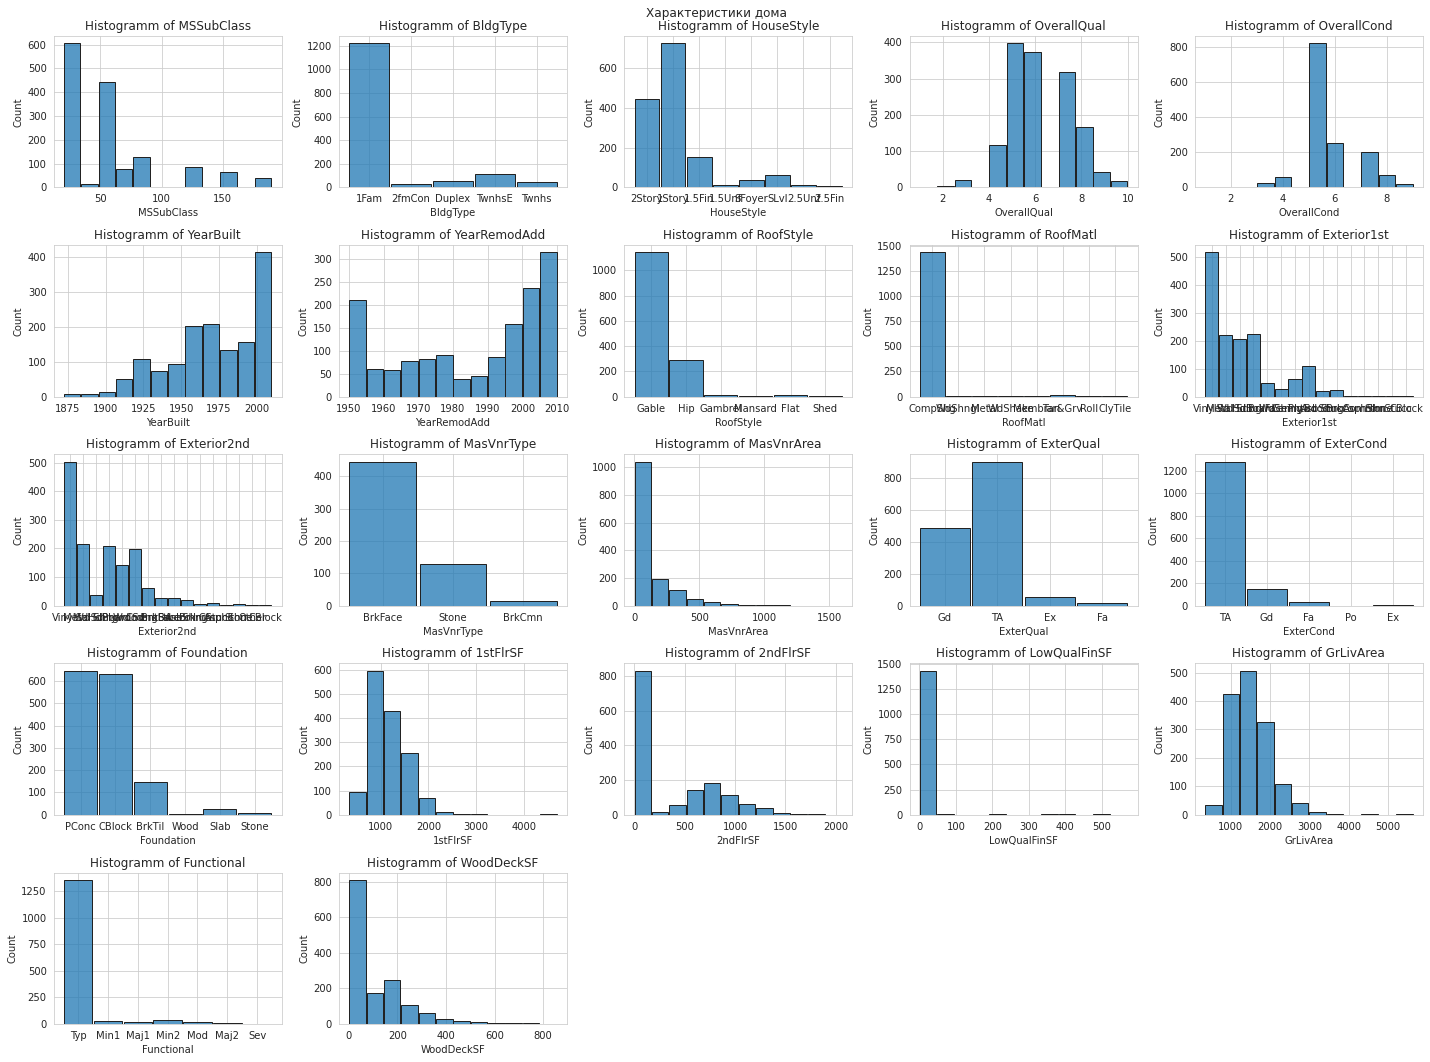

In [19]:
create_group_graphic(df_train, house_cols, 'Характеристики дома',)

#### Распределение значений удобств

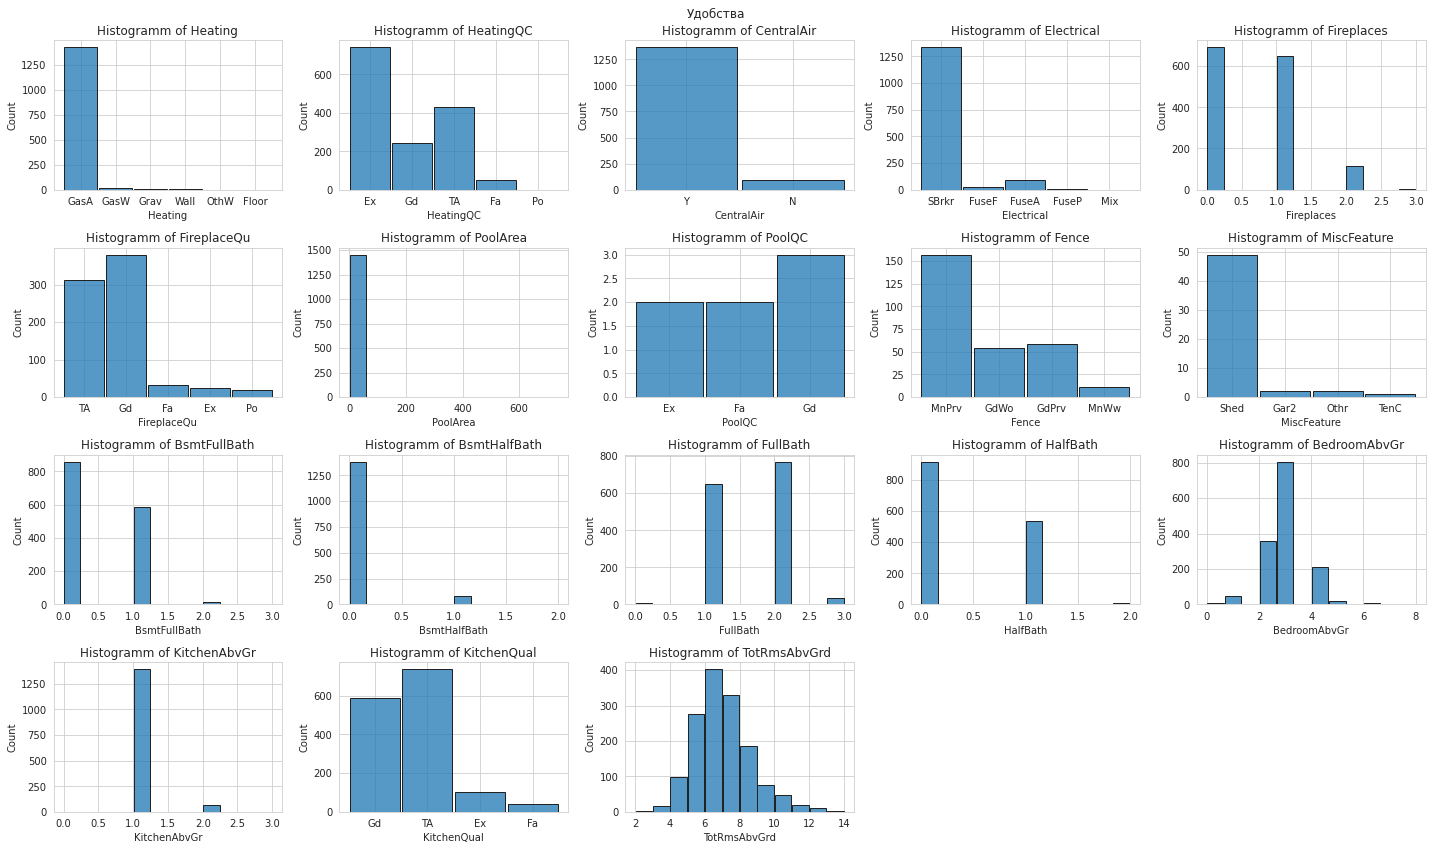

In [20]:
create_group_graphic(df_train, comfort_cols, 'Удобства',)

### Предложения на основе анализа распределения данных

#### Заполнение пропусков
* Для числовых признаков можно заменить пропуски 0 значением (т.к. пропуск таких значений соответствует отсутсвию признака);
* Отдельно можно выделить ряд перменных отображающих качество `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `HeatingQC`, `KitchenQual`, `FireplaceQu`, `GarageQual`, `GarageCond`, `PoolQC` (имеющие значения из набора: *Ex* - отлично, *Gd* - хорошо, *TA* - типичный, *Fa* - нормальный, *Po* - бедный). Заполним пропущенные значения для них специальным выделенным значением;
* Также отдельно можно выделить категориальные переменные описывающие характеристики гаража и подвала. Заменим пропуски в них специальным выделенным значением, чтобы в последствии удалить их после *OneHotEncoding*;
* В категориальных переменных имеющих менее 5% пропусков, заменим их модальным значением, в остальных случаях используем спциальное выделенное значение.

#### Удаление признаков
* Признаки `1stFlrSF`, `2ndFlSF` можно удалить т.к. он их сумма в точности равна признаку `GrLivArea`;
* Достаточно большое количетсво признаков имеют много одинаковых значений. Такие признаки можно удалить из модели;
* Фильтрация признаков, т.к. модель содержит довольно большое число признаков, после выполнения всех шагов предварительной обработки имеет смысл отфильтровать некоторые наименее значимые признаки.

#### Конструирование признаков
* Некоторые уникальные значения категориальных признаков встречаюстя крайне редко. Такие значения можно обьеденить, присвоим им некоторое специальное, выделенне значение;
* Ряд признаков имеют связанные значения (пары перменных с номерами 1 и 2 в составе). Можно проссумировать значения числовых переменных и категариальных (после выполненеия *OneHotEncoding*);
* Признаки `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch` можно обьеденить в одну переменную, хранящую общую площадь веранды.

#### Масштабирование и кодирование признаков
* Качественные признаки (имеющие значения из набора: *Ex* - отлично, *Gd* - хорошо, *TA* - типичный, *Fa* - нормальный, *Po* - бедный) (`ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `HeatingQC`, `KitchenQual`, `FireplaceQu`, `GarageQual`, `GarageCond`, `PoolQC`), можно попробовать закодировать при помощи *LabelEncoding*;
* Категориальные признаки `OverallQual` и `OverallCond` с количественной оценкой в диапазоне от 0 до 9, необходимо нормировать;
* Признак `MoSold` можно закодировать при помощи синусо-косинусного кодирования;
* Переменные имеющие только 2 уникальных значения можно бинаризовать;
* Категориальные признаки можно кодировать при помощи *OneHotEncoding*;
* Числовые признаки можно нормировать, при этом предварительно выполнив логарифмирование для признаков с 'тяжелыми хвостами'.

## 4. Предварительная обработка признаков

### Заполенение пропусков

#### Пропуски в числовых переменных

In [21]:
# Заполняем пропуски в числовых переменных 0
numeric_cols = unite.select_dtypes(include=np.number).columns
unite[numeric_cols] = unite[numeric_cols].fillna(0)

#### Пропуски в качественных переменных

In [22]:
# Заполняем пропуски в качественных переменных
q_cols = df_train.columns[df_train.columns.str.contains('.*(Qual|Cond|QC|Qu)$')]
unite[q_cols] = unite[q_cols].fillna('Na')

#### Пропуски в категориальных переменных

In [23]:
# Заполняем пропуски в категориальных переменных подвала и гаража
unite[bsmt_cols] = unite[bsmt_cols].fillna('Na')
unite[garage_cols] = unite[garage_cols].fillna('Na')

In [24]:
# Признак MSSubClass является категориальным хотя воспринимается как числовой
unite['MSSubClass'] = unite['MSSubClass'].astype(object)

# Заполняем пропуски в категориальных переменных
cat_cols = unite.select_dtypes(include=object).columns
cat_cols = np.setdiff1d(cat_cols, q_cols)

# Разделяем переменные
threshold = len(unite) * .05
many_nans_cat_cols = cat_cols[unite[cat_cols].isna().sum() > threshold]
less_nans_cat_cols = cat_cols[unite[cat_cols].isna().sum() <= threshold]

# У переменных с большим количеством пропусков заполняем их выделенными значениеми
unite[many_nans_cat_cols] = unite[many_nans_cat_cols].fillna('Na')
# У переменных с небольшим количеством пропусков заполняем их модальными значениями
unite[less_nans_cat_cols] = unite[less_nans_cat_cols].fillna(unite[less_nans_cat_cols].mode().iloc[0])

### Удаление признаков

#### Удаление повторяющихся признаков

Удалим признаки дублирующиеся в наборе данных

In [25]:
unite = unite.drop(['1stFlrSF', '2ndFlrSF', 'GarageArea'], axis=1)

#### Удаление признаков содержащих мало уникальных значений

Выведем признаки минимум 95% процентов значений которых совпадают

Признаки с минимум 95% одинаковых значений: Index(['Street', 'Utilities', 'LandSlope', 'RoofMatl', 'Heating',
       'LowQualFinSF', 'KitchenAbvGr', 'PoolArea', 'PoolQC', 'MiscFeature',
       'MiscVal'],
      dtype='object')


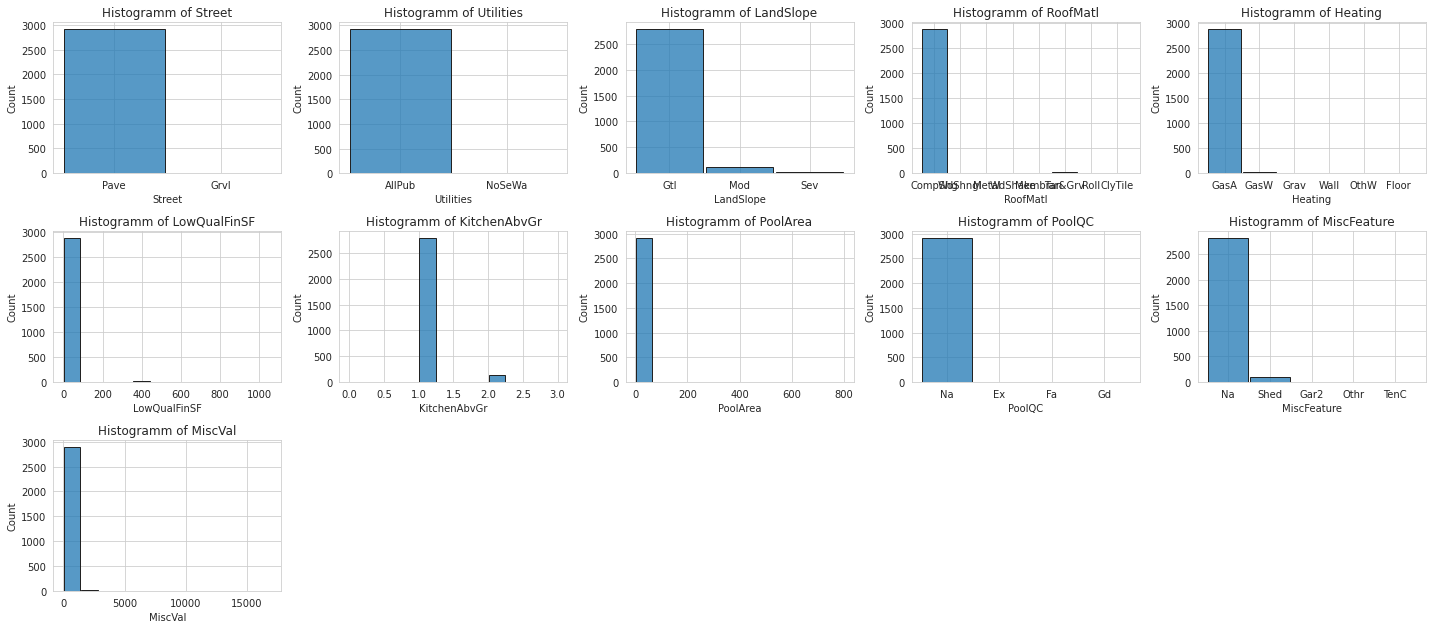

In [27]:
value_counts = unite.apply(pd.value_counts)

threshold = len(unite) * .95
# Отберем признаки с переменной имеющей 95% совпадающих значения
cond_same_val = unite.apply(lambda col: (col.value_counts() > threshold).any())
cols_same_val = unite.columns[cond_same_val]
# Отбираем те из них что не будут обьедененны с другими признаками (отберем парные и признаки беседки)
cols_same_val = cols_same_val[cols_same_val.str.contains('1|2|Porch') == False]

print(f'Признаки с минимум 95% одинаковых значений: {cols_same_val }')
create_group_graphic(unite, cols_same_val , n_cols=5,)

Удаляем признаки с большим количеством одинаковых значений

In [28]:
unite = unite.drop(cols_same_val, axis=1)

### Конструирование признаков

#### Признаки с редкими категориальными значениями
Выведем категориальные признаки с несколькими значениями, встречающимися реже чем в 5% от общей выборки.

Признаки чьи значения встречаются с частотой меньше 2%: Index(['BldgType', 'BsmtFinType2', 'Condition1', 'Condition2', 'Electrical',
       'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'Functional',
       'GarageType', 'HouseStyle', 'LandContour', 'MSZoning', 'Neighborhood',
       'RoofStyle', 'SaleCondition', 'SaleType'],
      dtype='object')


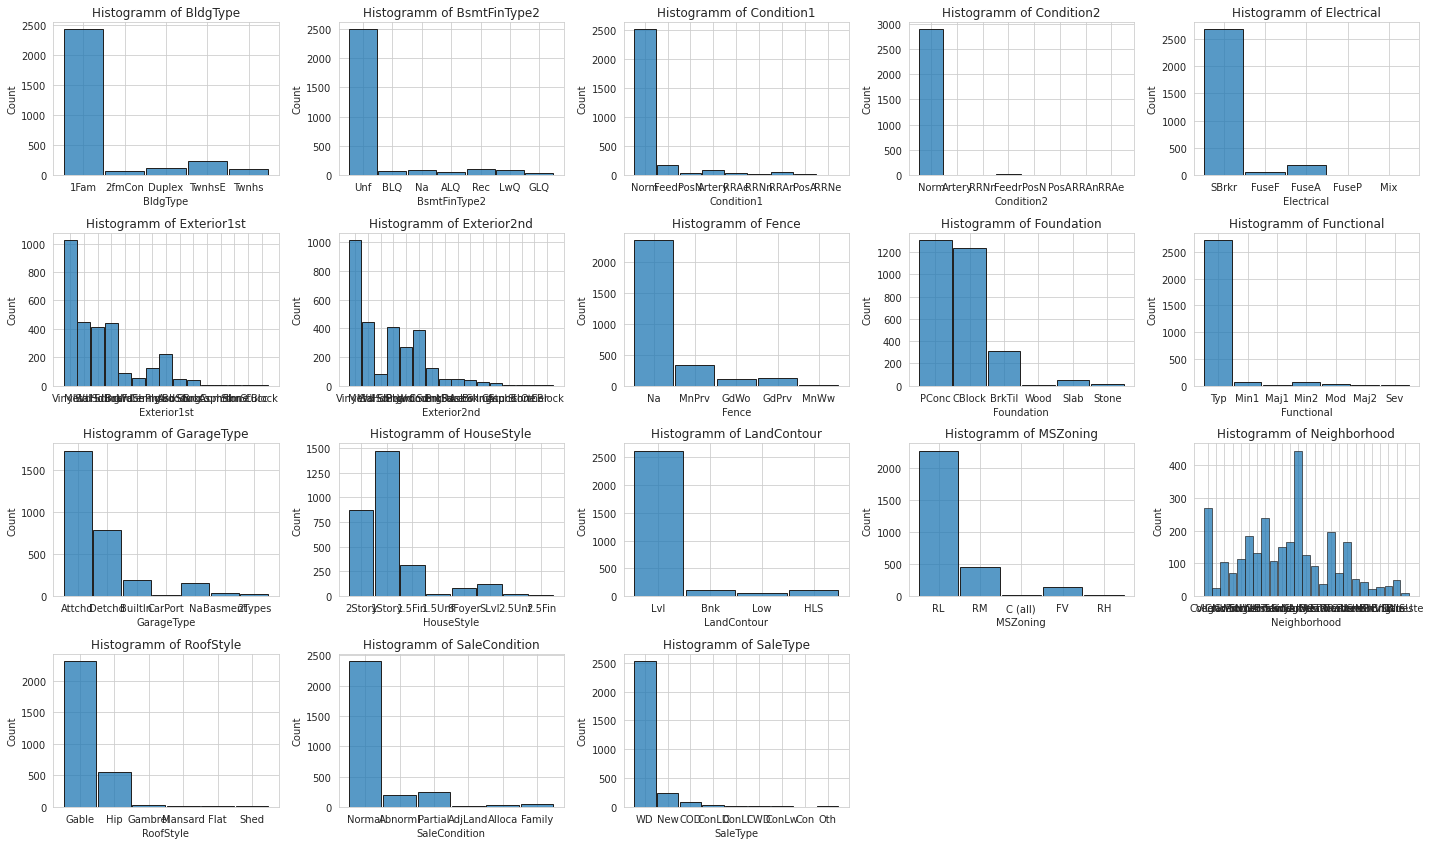

In [29]:
threshold = len(unite) * .05

# Выбираем категориальные переменные
cat_cols = unite.select_dtypes(include=object).columns
cat_cols = np.setdiff1d(cat_cols, q_cols)

# Выбираем столбцы содержащие более 1 значения, встречающегося реже чем в 5% от общей выборки
cond_rare_val = unite[cat_cols].apply(lambda col: (col.value_counts() < threshold).sum() > 2)
cols_rare_val = unite[cat_cols].columns[cond_rare_val]

print(f'Признаки чьи значения встречаются с частотой меньше 2%: {cols_rare_val}')
create_group_graphic(unite, cols_rare_val,)

Заполним редкие значения специальным значением

In [30]:
mask = unite[cols_rare_val].apply(lambda col: col.map(col.value_counts()) < threshold)
# Заменим редкие значения
unite[cols_rare_val] = unite[cols_rare_val].mask(mask, 'Mask')

#### Признаки со связанными значениями
Выведем пары признаков для визуализации их взаимной корреляции. Логично предположить что пары таких признаков должны рассматриваться совместно на этапе предобработки данных. Рассмотрим их взаимную корреляцию при помощи 2 мерных гистограмм распределения.

In [31]:
# Выберем все признаки содержащие номера 1 и 2 в составе
cols_1st = list(unite.columns[unite.columns.str.contains('1')])
cols_2nd = list(unite.columns[unite.columns.str.contains('2')])

# Выведем все пары признаков
print(f'1й признак в паре: {cols_1st}')
print(f'2й признак в паре: {cols_2nd}')

1й признак в паре: ['Condition1', 'Exterior1st', 'BsmtFinType1', 'BsmtFinSF1']
2й признак в паре: ['Condition2', 'Exterior2nd', 'BsmtFinType2', 'BsmtFinSF2']


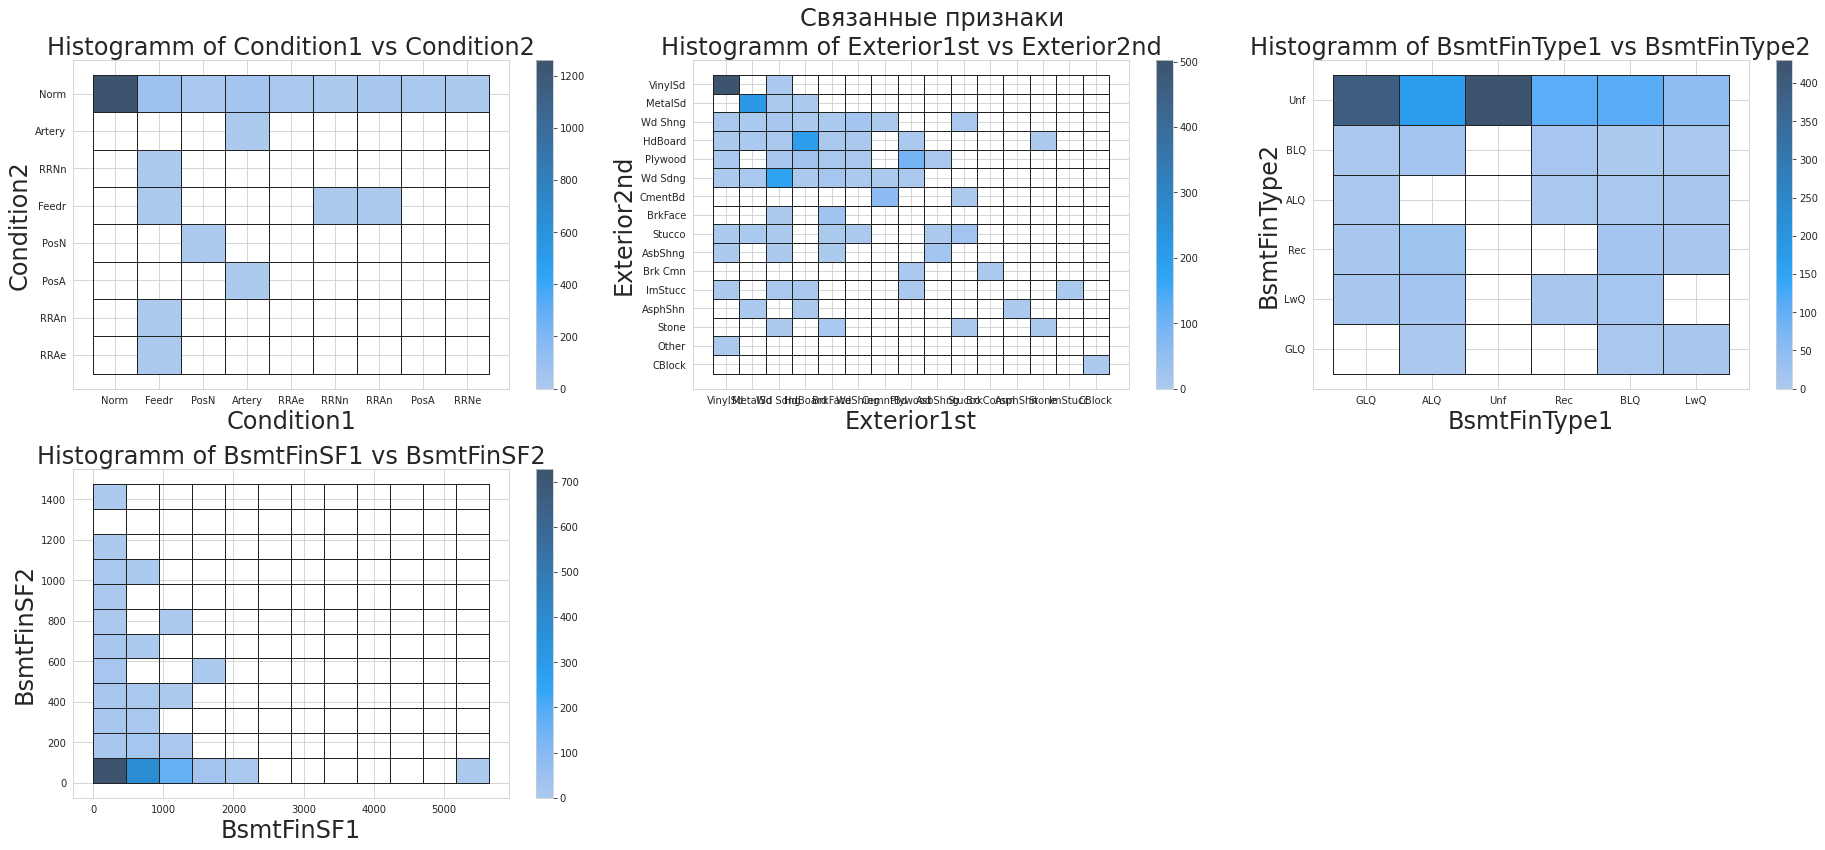

In [32]:
# Число строк и столбцов для вывода данных
n_cols = 3
n_rows = int(len(cols_1st) / n_cols) + 1
# Задаем размер сцены
plt.figure(figsize=(26, 12))

fontsize = 24
# Подпись сцены
plt.suptitle('Связанные признаки', fontsize=fontsize)

# Стриом 2 мерную гистгорамму распределения
for i, (c1, c2) in enumerate(zip(cols_1st, cols_2nd)):
    # Создаем подграфик
    plt.subplot(n_rows, n_cols, i+1,)
    # Подпись сверху графика
    plt.title(label=f"Histogramm of {c1} vs {c2}", fontsize=fontsize,)
    # 2 мерная гистограмма распределения признаков
    ax = sns.histplot(
        data=df_train, x=c1, y=c2, edgecolor=edgecolor, palette=palette,
        shrink=shrink, bins=bins, multiple="dodge", cbar=True, 
    )
    # Подписи осей
    plt.xlabel(c1, fontsize=fontsize)
    plt.ylabel(c2, fontsize=fontsize)
    
# Автоматическая настройка интервалов между подграфиками
plt.tight_layout()

Можно заметить что у категориальных переменных (`Condition1`, `Exterior1st`, `BsmtFinType1`, `Condition2`, `Exterior2nd`, `BsmtFinType2`), значения зачастую отличаются. Выполним для них *OneHotEncoding*, получив для каждого значения признака разряженное векторное представление, после чего проссумируем вектора признаков для каждой переменной.

In [33]:
cols_1st = ['Condition1', 'Exterior1st', 'BsmtFinType1']
cols_2nd = ['Condition2', 'Exterior2nd', 'BsmtFinType2']
cols_names = ['Condition', 'Exterior',  'BsmtFinType']

# Метод для кодирования парных признаков
def encode_pair(df, col1, col2, out_name):
    # Подготавливаем данные для отправки в модель
    x1 = np.array(unite[col1]).reshape(-1, 1)
    x2 = np.array(unite[col2]).reshape(-1, 1)
    
    # Создаем OneHotEncoder обученный на обьединении значений пары признаков
    enc = preprocessing.OneHotEncoder().fit(np.concatenate([x1, x2]))
    # Выполняем кодирование признаков (получаем их векторные представления)
    trans1 = enc.transform(x1).toarray()
    trans2 = enc.transform(x2).toarray()
    # Обьеденяеи результаты кодирования
    trans = ((trans1 + trans2) != 0)
    # Получаем именна сгенерированных признаков
    features = enc.get_feature_names_out([out_name])
    # Создаем новые признаки
    df[features] = trans
    # Удаляем старые признаки из модели
    df = df.drop([c1, c2], axis=1)
    
    return df
    
for name, c1, c2 in zip(cols_names, cols_1st, cols_2nd):
    unite = encode_pair(unite, c1, c2, name)

Просуммируем значения переменных `BsmtFinSF1` и `BsmtFinSF2` (сумма `1stFlrSF` и `2ndFlrSF` уже записанна в переменной `GrLivArea`)

In [34]:
unite['BsmtFinSF'] = unite['BsmtFinSF1'] + unite['BsmtFinSF2']
# Удаляем старые признаки из модели
unite = unite.drop(['BsmtFinSF1', 'BsmtFinSF2',], axis=1)

#### Обьединение признаков

Рассмотрим распределние размеров беседок различных типов (в тех случаях когда их размер отличен от 0) и их корреляцию со стоимостью учатска.

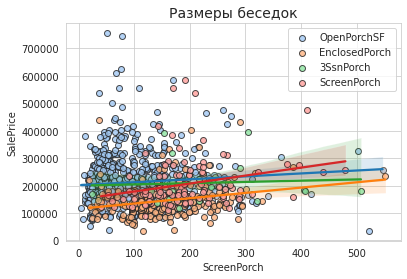

In [35]:
# Задаем размер сцены
plt.figure(figsize=(6, 4))
# Подпись сцены
plt.title('Размеры беседок', fontsize=14)

for i, col in enumerate(porch_cols):
    color = palette[i]
    sns.regplot(
        data=df_train[df_train[col] > 0], x=col, y=target_var, label=col,
        scatter_kws={'edgecolor': edgecolor, 'color': color,},
    )
    plt.legend()
plt.show()

Можно заметить что цена имеет крайне сходую зависимость от беседок всех размеров. Рассмотрим теперь их взаимные корреляции.

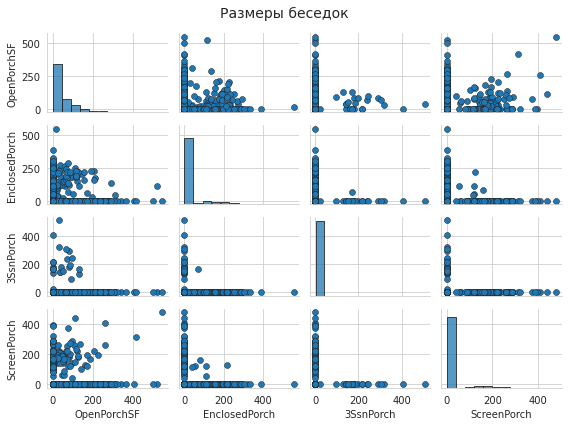

In [36]:
g = sns.PairGrid(df_train[porch_cols], palette=palette,)

# Подпись сцены
g.fig.suptitle('Размеры беседок', fontsize=14)
# Задаем размер сцены
g.fig.set_size_inches(8, 6)
# Задаем тип отоброжения распределения переменных
g.map_diag(sns.histplot, edgecolor=edgecolor, bins=bins, shrink=shrink,)
# Задаем тип отоброжения взаимных корреляций
g.map_offdiag(sns.scatterplot, edgecolor=edgecolor,)
# Автоматическая настройка интервалов между подграфиками
plt.tight_layout()

Значения переменных практически не коррелированны. Создадим одну переменную отвечающую за общий размер беседки.

In [37]:
unite['Porch'] = unite[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)
# Удаляем старые признаки из модели
unite = unite.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',], axis=1)

### Масштабирование и кодирование признаков

#### Кодирование качественных признаков

Выведем распределение качественных признаков. Разделим их на признаки с качественными и целочисленными оценками. В каждой группе рассмотрим корреляцию категориальных значений с целевой переменной.

In [38]:
q_cols = unite.columns[unite.columns.str.contains('.*(Qual|Cond|QC|Qu)$')]

vals_qual = np.array(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'Na',])
vals_eval = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,])

qual_cols = list(q_cols[unite[q_cols].isin(vals_qual).any()])
eval_cols = list(q_cols[unite[q_cols].isin(vals_eval).any()])

print(f'Признаки с качественными оценками: {qual_cols}')
print(f'Признаки с количественными оценками: {eval_cols}')

Признаки с качественными оценками: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
Признаки с количественными оценками: ['OverallQual', 'OverallCond']


Рассмотрим коррелцию категориальных признаков (с качественной оценкой) с целевой переменной

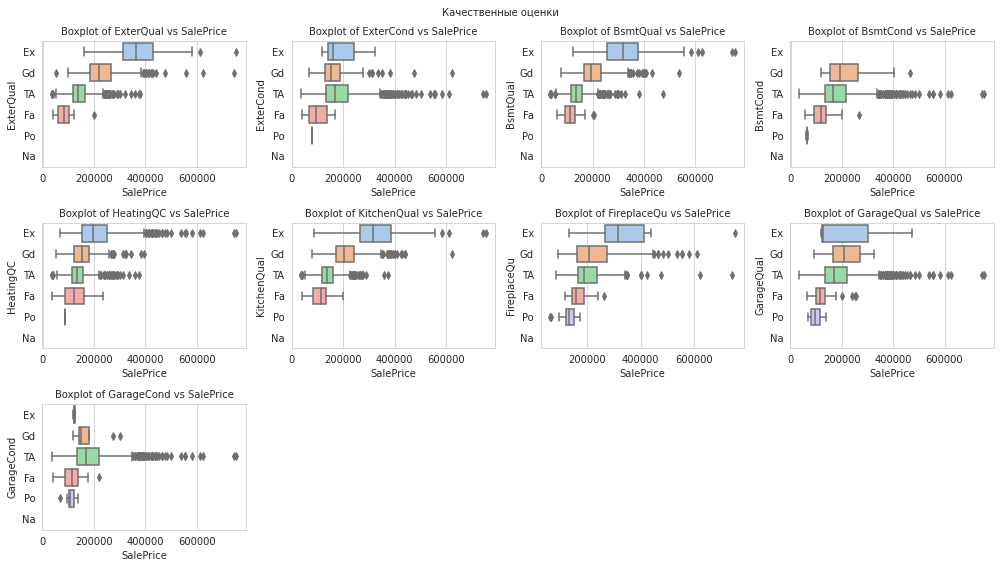

In [39]:
# Число строк и столбцов для вывода данных
n_cols = 4
n_rows = int(len(qual_cols) / n_cols) + 1
# Задаем размер сцены
plt.figure(figsize=(14, 8))

fontsize = 10
# Подпись сцены
plt.suptitle('Качественные оценки', fontsize=fontsize,)

# Стриом 2 мерную гистгорамму распределения
for i, col in enumerate(qual_cols):
    # Создаем подграфик
    plt.subplot(n_rows, n_cols, i+1,)
    # Подпись сверху графика
    plt.title(label=f"Boxplot of {col} vs {target_var}", fontsize=fontsize,)
    # 2 мерная гистограмма распределения признаков
    ax = sns.boxplot(
        data=df_train, y=col, x=target_var, palette=palette, order=vals_qual, orient='h',
    )
    # Подписи осей
    plt.xlabel(target_var, fontsize=fontsize)
    plt.ylabel(col, fontsize=fontsize)
    
# Автоматическая настройка интервалов между подграфиками
plt.tight_layout()

Рассмотрим коррелцию категориальных признаков (с количественной оценкой) с целевой переменной

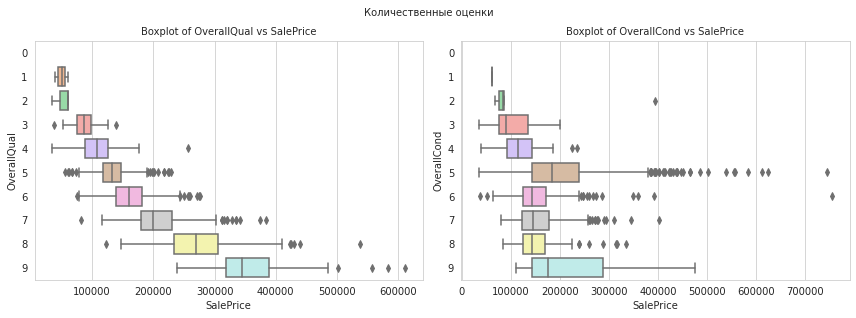

In [40]:
# Число строк и столбцов для вывода данных
n_cols = 2
n_rows = int(len(eval_cols) / n_cols) + 1
# Задаем размер сцены
plt.figure(figsize=(12, 8))

fontsize = 10
# Подпись сцены
plt.suptitle('Количественные оценки', fontsize=fontsize,)

# Стриом 2 мерную гистгорамму распределения
for i, col in enumerate(eval_cols):
    # Создаем подграфик
    plt.subplot(n_rows, n_cols, i+1,)
    # Подпись сверху графика
    plt.title(label=f"Boxplot of {col} vs {target_var}", fontsize=fontsize,)
    # 2 мерная гистограмма распределения признаков
    ax = sns.boxplot(
        data=df_train, y=col, x=target_var, palette=palette, order=vals_eval, orient='h',
    )
    # Подписи осей
    plt.xlabel(target_var, fontsize=fontsize)
    plt.ylabel(col, fontsize=fontsize)
    
# Автоматическая настройка интервалов между подграфиками
plt.tight_layout()

В целом между значениями признаков и целевой переменной присутсвует положительная корреляция. Закодируем значения качественной переменной при помощи *LabelEncoding* сохраняя указанный порядок переменных (*Ex, Gd, TA, Fa, Po, Na*).

In [41]:
le = preprocessing.LabelEncoder()
le.classes_ = vals_qual[::-1]

# Выполним LabelEncoding для качественных признаков
unite[qual_cols] = unite[qual_cols].apply(lambda col: le.transform(col))

Нормируем качественные и количественные оценки

In [42]:
unite[qual_cols] = unite[qual_cols] / (len(vals_qual) - 1)
unite[eval_cols] = unite[eval_cols] / len(vals_eval)

#### Кодирование циклических признаков

Закодируем категориальные переменные при помощи сиунсо-косинусоидального кодирования. Поскольку данные переменные являются циклическими такой тип кодирования позволяет сохранить на них отношения порядка, хотя и является несколько более сложным в интерпритации.

*Синусно-косинусное преобразование* - преобразует циклический признак, сохраняя отношения порядка на его значениях, в два синтетических.

In [43]:
# Класс для выполнения синусо-косинусоидального кодирования
class SinCosEncoder(base.TransformerMixin):
    def __init__(self):
        super().__init__()
        self.max_values = None
    
    def fit(self, X, y=None):
        self.max_values = np.max(X, axis=0)
        return self

    def transform(self, X, y=None):
        cos = np.cos(X * 2.0 * np.pi / self.max_values)
        sin = np.sin(X * 2.0 * np.pi / self.max_values)
        return cos, sin

In [44]:
sce = SinCosEncoder()

sn, cs = sce.fit_transform(unite['MoSold'].values.astype(int))
unite['MoSold_sin'] = sn
unite['MoSold_cos'] = cs
unite = unite.drop(['MoSold'], axis=1)

#### Бинаризация признаков
Выполним бинаризацию для признаков имеющих только 2 уникальных значения (чтобы не выполнять для них *OneHotEncoding*)

In [45]:
binary_cols = unite.columns[unite.nunique() == 2]
unite[binary_cols] = unite[binary_cols].apply(lambda col: le.fit_transform(col)).astype(bool)

#### Кодирование категориальных признаков

Выполним кодирование категориальных признаков при помощи  *OneHotEncoding*

In [46]:
unite['MSSubClass'] = unite['MSSubClass'].astype(object)
cat_cols = unite.select_dtypes(include=object).columns

# Выполним OneHotEncoding
unite = pd.get_dummies(unite, columns=cat_cols, drop_first=False,)
# Удалим категориальные признаки с специальным значением для признаков гаража и подвала
unite = unite.drop(unite.columns[unite.columns.str.contains('Na')], axis=1)
# Удалим атегориальные признаки с специальным значением для редких переменных
unite = unite.drop(unite.columns[unite.columns.str.contains('Mask')], axis=1)

#### Нормирование числовых признаков

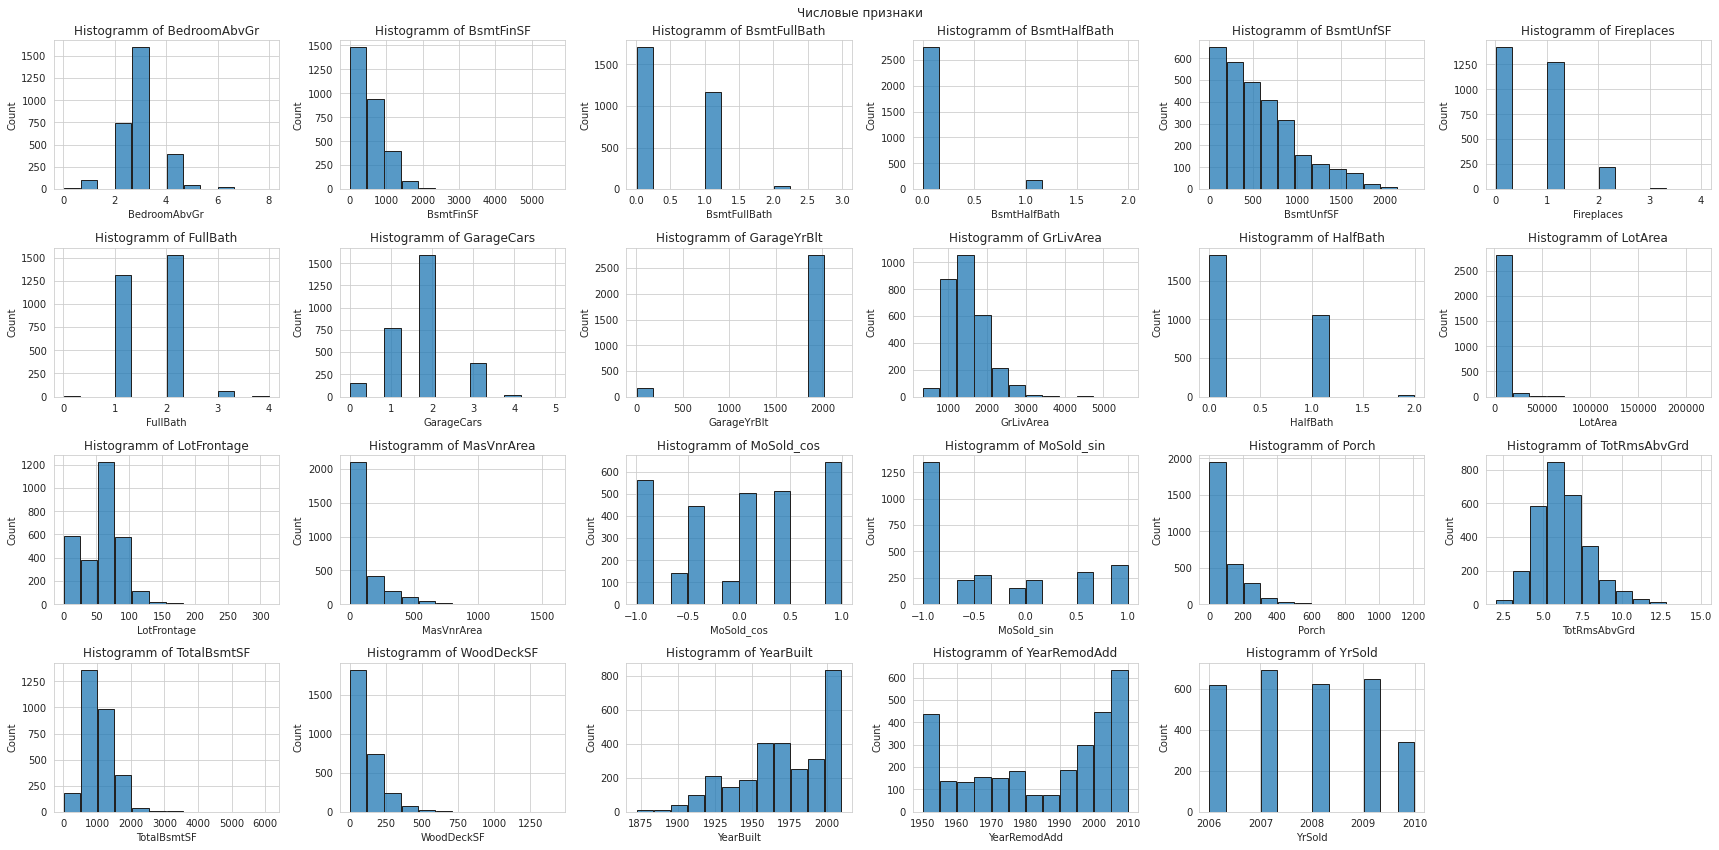

In [47]:
# Получаем все числовые признаки
numerical_cols = unite.select_dtypes(include=np.number).columns
numerical_cols = np.setdiff1d(numerical_cols, q_cols)

create_group_graphic(unite, numerical_cols, 'Числовые признаки', n_cols=6)

Выполним предварительно логарифмирования для некоторых переменных

In [48]:
log_cols = [
    'BsmtFinSF', 'BsmtUnfSF', 'GrLivArea', 'LotArea', 'LotFrontage',
    'MasVnrArea', 'Porch', 'TotalBsmtSF', 'WoodDeckSF',
]

unite[log_cols] = np.log(unite[log_cols] + 1)
unite[numerical_cols] = preprocessing.MinMaxScaler().fit_transform(unite[numerical_cols])

### Корреляционный анализ

#### Устранение мультиколлинеарности

Удалим признаки с коэффициентом корреляции Пирсона выше 0.8

In [49]:
corr = unite.corr(method='pearson')
unique_pairs = corr.unstack()[corr.unstack() != 1].drop_duplicates()
unique_pairs[np.abs(unique_pairs) > .8]

BsmtCond          TotalBsmtSF              0.820857
GrLivArea         TotRmsAbvGrd             0.804969
Fireplaces        FireplaceQu              0.861735
GarageYrBlt       GarageQual               0.944441
                  GarageCond               0.949602
GarageQual        GarageCond               0.946656
MSSubClass_50     HouseStyle_1.5Fin        0.932556
MSZoning_RL       MSZoning_RM             -0.808091
LotShape_IR1      LotShape_Reg            -0.932816
RoofStyle_Gable   RoofStyle_Hip           -0.939469
Electrical_FuseA  Electrical_SBrkr        -0.862954
PavedDrive_N      PavedDrive_Y            -0.871296
SaleType_New      SaleCondition_Partial    0.986573
dtype: float64

Удалим одну из переменных в каждой корелированной паре признаков

In [50]:
corr_cols = np.unique([k[1] for k in unique_pairs[np.abs(unique_pairs) > .8].keys()])
unite = unite.drop(corr_cols, axis=1)

####  Удаление признаков слабокореллированных с целевой переменной

Рассмотрим признаки рассортированные по их модулю корреляции с целевой переменной

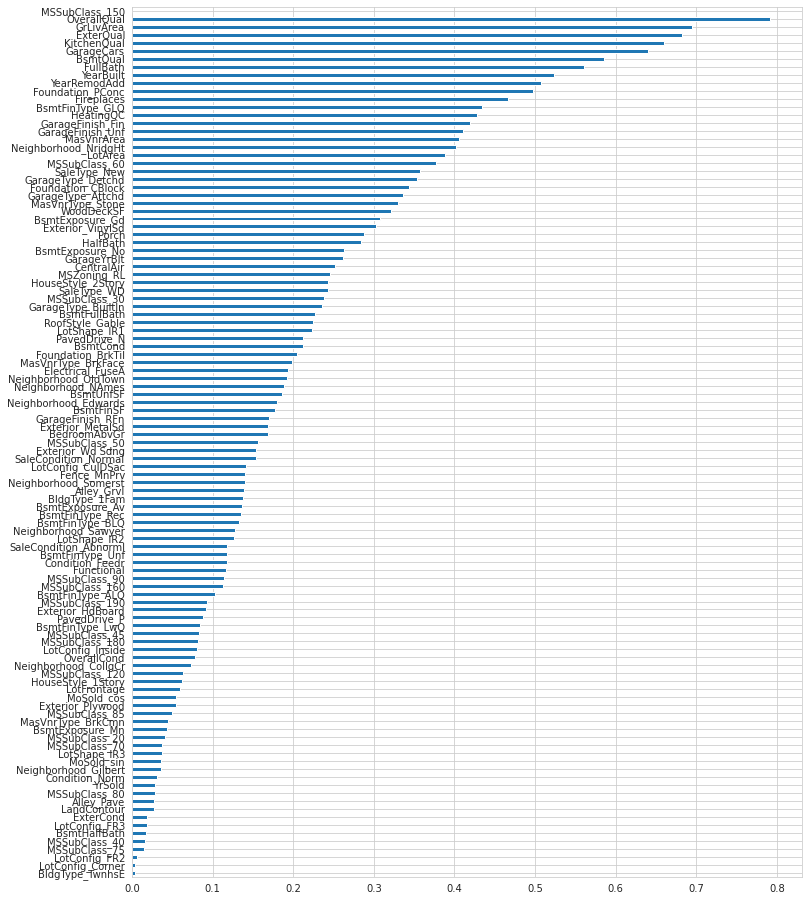

In [51]:
corr_target = unite[:df_train.shape[0]].corrwith(targets, method='pearson')
sort_corr_target = np.abs(corr_target).sort_values()
sort_corr_target.plot(kind='barh', figsize=(12, 16),)
plt.show()

Удалим из модели все слабо кореллирующие с целевой переменной признаки

In [52]:
weak_corr_cols = corr_target[np.abs(corr_target) <= .1].index
corr_target[weak_corr_cols]

LotFrontage             0.059762
LandContour             0.027545
OverallCond            -0.077856
ExterCond               0.018899
BsmtHalfBath           -0.016844
YrSold                 -0.028923
Condition_Norm          0.030676
Exterior_HdBoard       -0.091262
Exterior_Plywood       -0.054547
BsmtFinType_LwQ        -0.084577
MoSold_sin              0.036300
MoSold_cos             -0.055101
MSSubClass_20           0.041274
MSSubClass_40          -0.016366
MSSubClass_45          -0.082912
MSSubClass_70          -0.036883
MSSubClass_75           0.015265
MSSubClass_80          -0.028646
MSSubClass_85          -0.049137
MSSubClass_120          0.062944
MSSubClass_180         -0.082215
MSSubClass_190         -0.093578
Alley_Pave             -0.027655
LotShape_IR3            0.036720
LotConfig_Corner        0.004145
LotConfig_FR2          -0.006859
LotConfig_FR3           0.018186
LotConfig_Inside       -0.080538
Neighborhood_CollgCr    0.072626
Neighborhood_Gilbert    0.035940
BldgType_T

In [53]:
unite = unite.drop(weak_corr_cols, axis=1)
unite.shape

(2919, 74)

## 5. Обучение моделей

### Подготовка к обучению моделей

Выполним разделение данных на тренировочные и тестовые. В этом наборе данных, тренировочные данные были отделенны заранее, так что просто отберем первые *1460* все записи для обучения.

In [54]:
X_train = unite[:df_train.shape[0]]
X_test = unite[df_train.shape[0]:]
# Будем обучать модель предсказывающую логарифм стоимости
y_train = np.log(targets)

(X_train.shape, y_train.shape), (X_test.shape)

(((1460, 74), (1460,)), (1459, 74))

Выберем параметры для поиска по решетке. Оценивать каждую модель будем по следующим 3 метрикам:
* ***neg_root_mean_squared_error*** - среднеквадратичная ошибка. Среднеквадратичная разность между предсказаниями модели и действительными значениями;
* ***neg_mean_absolute_percentage_error*** - средняя абсолютная процентная ошибка. Средняя отношение ошибки к предсказываемой переменной;
* ***r2*** - коэфиицент обьясненной дисперсии. Доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью.

In [55]:
scores = ['r2', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error',]
refit = 'r2'
# Число фолдов для кроссвалидации
cv = 5

Метод для визуализации k лучших параметров поиска по решетке

In [56]:
def get_best_k_gs_res(gs, k=5, by='mean_test_' + refit, scores=scores):
    # Получаем оценку точности пердсказаний
    res = pd.DataFrame(gs.cv_results_)
    # Сортируем предсказания по целевой переменной
    res = res.sort_values(by=by, inplace=False, ascending=False)
    # Отбираем k лучших результатов
    return res.iloc[:k][
        ['param_' + x for x in gs.param_grid.keys()] + ['mean_test_' + x for x in scores]
    ]

### Обучение моделей

Сравним между собой несолько моделей, с оптимальным подбором их гиперпараметров при помощи кроссвалидации по сетке.
* ***Линейная регерссия*** - Настраивает уравнение линейной регресии (коэффициенты линейной корреляции с предсказываемой переменной для каждого признака и свободный член);
* ***Случайный лес*** - Строит набор решающих деревьев (слабых классификаторов), на случайных подмножествах признаков и обьектов, вынося решения о значении предсказываемой переменной при помощи голосования;
* ***Градиентный бустинг*** - Строит последовательность моделей, где каждая модель обучается на остатках (разницей между реальным и предсказываемым значением) для предыдущей модели, усредняя их результаты при попомщи суммирования.

#### Линейная регрессия

In [57]:
elastic_net = linear_model.ElasticNet(random_state=random_state,)
elastic_net_params = {
    'alpha': [0.0, 0.25, 0.5, 0.75, 1.0,],
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0,],
}

elastic_net_gs = model_selection.GridSearchCV(elastic_net, elastic_net_params, cv=cv, scoring=scores, refit=refit,)
elastic_net_gs.fit(X_train, y_train)

# Рассмотрим параметры наилучших моделей
get_best_k_gs_res(elastic_net_gs)

param_alpha param_l1_ratio  mean_test_r2  \
0         0.0            0.0       0.88097   
2         0.0            0.5       0.88097   
3         0.0           0.75       0.88097   
4         0.0            1.0       0.88097   
1         0.0           0.25       0.88097   

   mean_test_neg_mean_absolute_percentage_error  \
0                                     -0.007958   
2                                     -0.007958   
3                                     -0.007958   
4                                     -0.007958   
1                                     -0.007958   

   mean_test_neg_root_mean_squared_error  
0                              -0.137059  
2                              -0.137059  
3                              -0.137059  
4                              -0.137059  
1                              -0.137059

#### Случайный лес

In [58]:
random_forest = ensemble.RandomForestRegressor(random_state=random_state,)
random_forest_params = {
    'max_depth' : [8, 16, 32,],
    'n_estimators': [160, 80,],
    'min_samples_split': [4, 7, 10,],
    'min_samples_leaf': [4, 7, 10,],
}


random_forest_gs = model_selection.GridSearchCV(random_forest, random_forest_params, cv=cv, scoring=scores, refit=refit)
random_forest_gs = random_forest_gs.fit(X_train, y_train)
# Рассмотрим параметры наилучших моделей
get_best_k_gs_res(random_forest_gs)

param_max_depth param_n_estimators param_min_samples_split  \
36              32                160                       4   
38              32                160                       7   
20              16                160                       7   
18              16                160                       4   
39              32                 80                       7   

   param_min_samples_leaf  mean_test_r2  \
36                      4      0.862782   
38                      4      0.862782   
20                      4      0.862778   
18                      4      0.862778   
39                      4      0.862328   

    mean_test_neg_mean_absolute_percentage_error  \
36                                     -0.008334   
38                                     -0.008334   
20                                     -0.008334   
18                                     -0.008334   
39                                     -0.008343   

    mean_test_neg_root_mean_squared_error  
36                              -0.147634  
38                              -0.147634  
20                              -0.147636  
18                              -0.147636  
39                              -0.147871

#### Градиентный бустинг

In [59]:
gradient_boost = ensemble.GradientBoostingRegressor(random_state=random_state,)
gradient_boost_params = {
    'n_estimators': [100, 200, 400, 800,],
    'max_depth': [3, 4, 5,],
    'subsample': [0.2, 0.5, 1.0,],
}

gradient_boost_gs = model_selection.GridSearchCV(gradient_boost, gradient_boost_params, cv=cv, scoring=scores, refit=refit)
gradient_boost_gs.fit(X_train, y_train)
# Рассмотрим параметры наилучших моделей
get_best_k_gs_res(gradient_boost_gs)

param_n_estimators param_max_depth param_subsample  mean_test_r2  \
5                 200               3             1.0      0.890617   
2                 100               3             1.0      0.890067   
8                 400               3             1.0      0.889709   
11                800               3             1.0      0.889030   
4                 200               3             0.5      0.886279   

    mean_test_neg_mean_absolute_percentage_error  \
5                                      -0.007609   
2                                      -0.007672   
8                                      -0.007633   
11                                     -0.007700   
4                                      -0.007616   

    mean_test_neg_root_mean_squared_error  
5                               -0.131895  
2                               -0.132212  
8                               -0.132433  
11                              -0.132857  
4                               -0.134419

## 6. Оценка моделей

Создадим словарь всех моделей

In [60]:
gs = {
    'LinearReg': elastic_net_gs,
    'RandomForest': random_forest_gs,
    'GradientBoost': gradient_boost_gs,
}

In [61]:
evals = pd.DataFrame({
    **{'model': list(gs.keys())}, 
    **{s: [round(gs[k].cv_results_['mean_test_' + s][gs[k].best_index_], 4) for k in gs] for s in scores},
})
evals.sort_values(by=scores[0])[::-1]

model      r2  neg_mean_absolute_percentage_error  \
2  GradientBoost  0.8906                             -0.0076   
0      LinearReg  0.8810                             -0.0080   
1   RandomForest  0.8628                             -0.0083   

   neg_root_mean_squared_error  
2                      -0.1319  
0                      -0.1371  
1                      -0.1476

Построим визуализацию

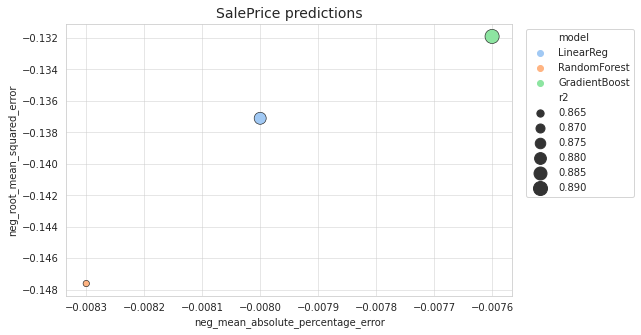

In [62]:
plt.figure(figsize=(8, 5))

plt.title(label=f"{target_var} predictions", fontsize=14)
ax = sns.scatterplot(
    data=evals, x=scores[1], y=scores[2], size=scores[0], sizes=(40, 200), hue='model', 
    edgecolor=edgecolor, palette=palette, legend="brief",
)
plt.legend(bbox_to_anchor=(1.02 , 1))
plt.grid(True, alpha=.6)

Наилучшей моделью является `GradientBoost`. Используем ее для генерации предсказаний.

In [63]:
model = gs['GradientBoost'].best_estimator_
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
y_pred.shape

(1459,)

Запишем предсказания модели

In [63]:
submission = pd.DataFrame({
    "Id": df_test["Id"],
    "SalePrice": y_pred,
})
submission.to_csv('./data/submission.csv', index=False)